Contributors: Rohit Singh Rathaur, Girish L.

Copyright 2021 [Rohit Singh Rathaur, BIT Mesra and Girish L., CIT GUBBI, Karnataka]

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


We are importing the libraries:

- TensorFlow: to process and train the model
- Matplotlib: to plot the training anf loss curves
- Pandas: used for data analysis and it allows us to import data from various formats
- Numpy: For array computing

In [ ]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

We are reading the CSV file using `read_csv` function and storing it in a DataFrame named `df_Ellis`

In [ ]:
df_Ellis  = pd.read_csv("/gdrive/MyDrive/LFN Anuket/Analysis/data/Final/Ellis_FinalTwoConditionwithOR.csv")
df_Ellis

,Timestamp,ellis-cpu.system_perc,ellis-cpu.wait_perc,ellis-load.avg_1_min,ellis-mem.free_mb,ellis-net.in_bytes_sec,ellis-net.out_packets_sec,Label
0,14-09-2016 0:00,0.5,12.9,1.730,3949,5413.200,62.067,1
1,14-09-2016 0:00,0.4,10.3,1.790,3950,5201.667,59.567,1
2,14-09-2016 0:01,0.4,11.8,1.520,3950,5370.733,61.200,1
3,14-09-2016 0:01,0.4,12.9,1.430,3949,5292.467,60.400,1
4,14-09-2016 0:02,0.5,12.1,1.440,3950,5318.167,61.700,1
...,...,...,...,...,...,...,...,...
176995,13-12-2016 21:20,0.4,0.3,0.030,3484,230.967,2.167,0
176996,13-12-2016 21:20,0.2,0.3,0.018,3484,218.433,0.767,0
176997,13-12-2016 21:21,0.6,0.3,0.010,3483,160.967,1.867,0
176998,13-12-2016 21:21,0.6,0.3,0.007,3484,188.367,2.100,0


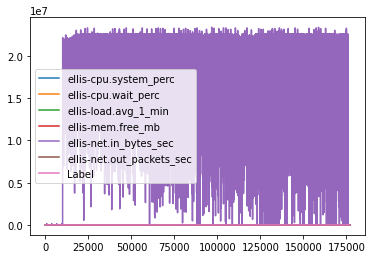

In [ ]:
df_Ellis.plot()

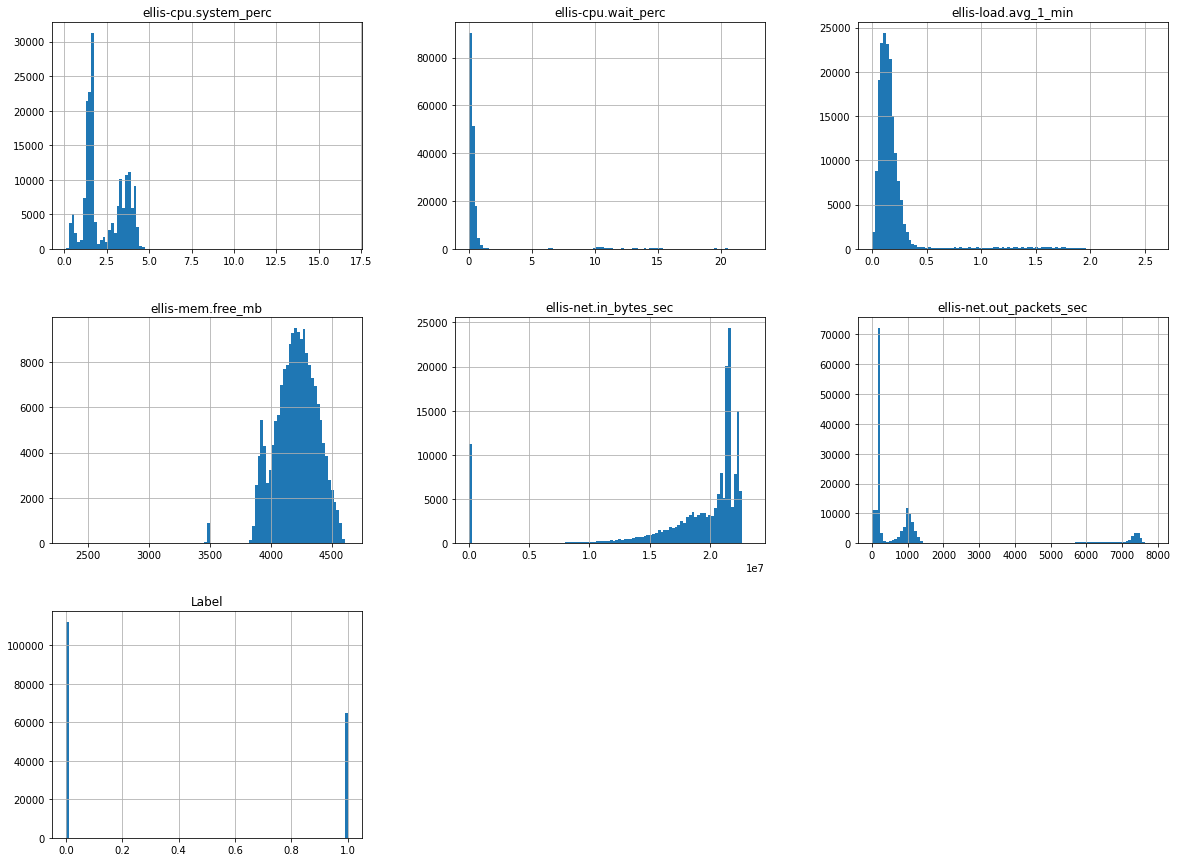

In [ ]:
# we show here the hist
df_Ellis.hist(bins=100,figsize=(20,15))
#save_fig("attribute_histogram_plots")
plt.show()

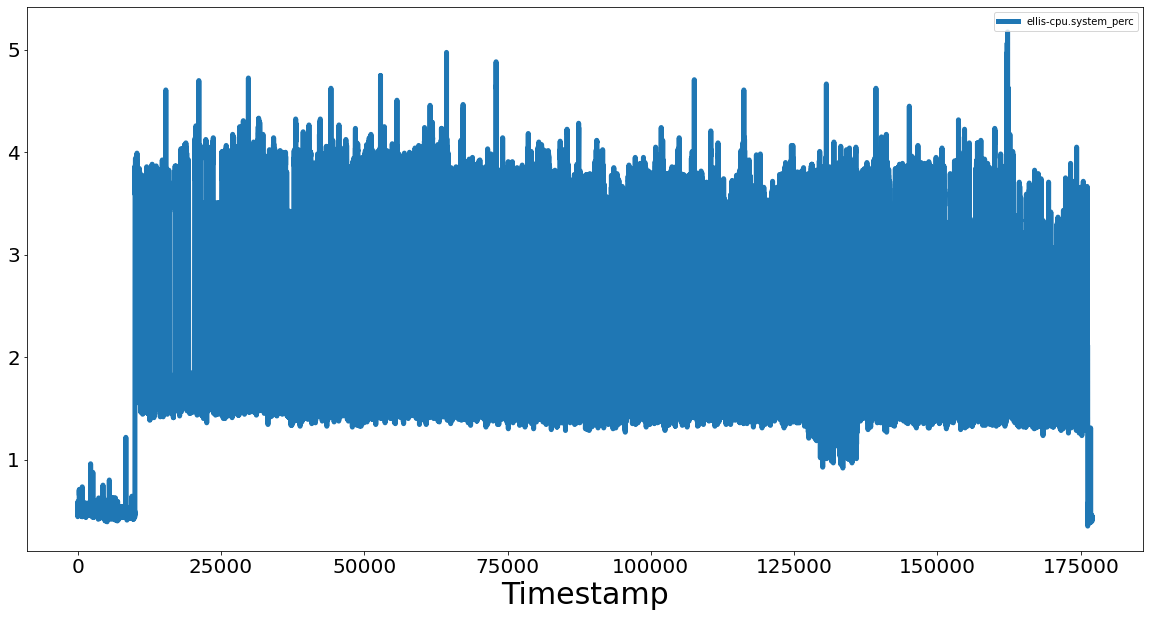

In [ ]:
cpu_system_perc = df_Ellis[['ellis-cpu.system_perc']] 
cpu_system_perc.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20) 
plt.xlabel('Timestamp', fontsize=30);

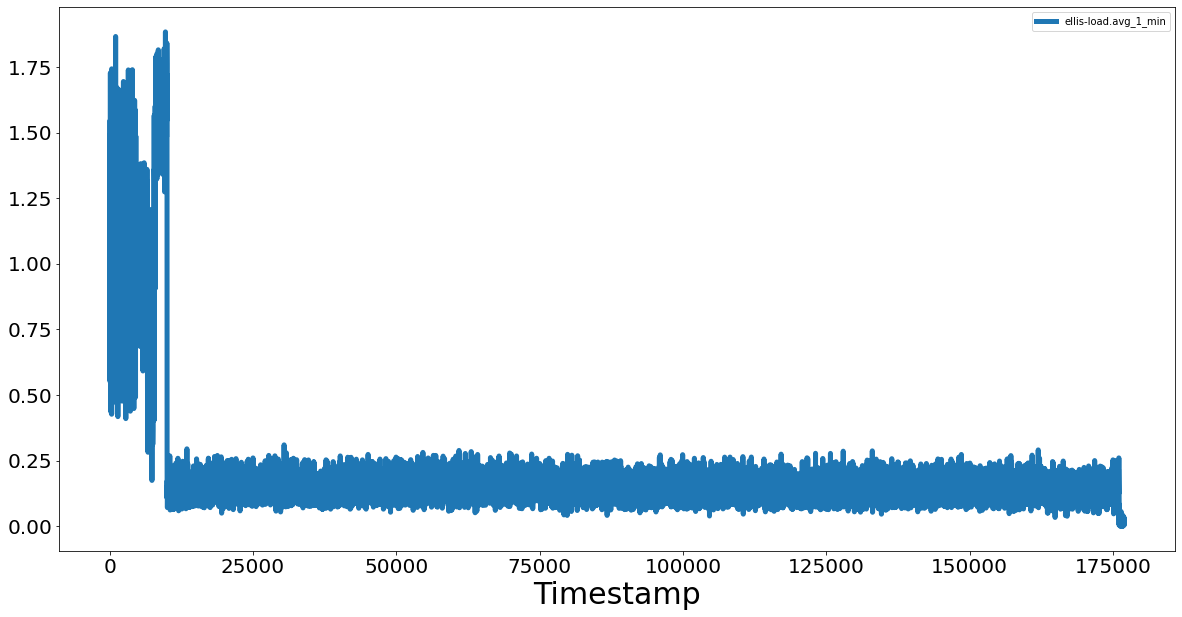

In [ ]:
load_avg_1_min = df_Ellis[['ellis-load.avg_1_min']] 
load_avg_1_min.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20) 
plt.xlabel('Timestamp', fontsize=30);

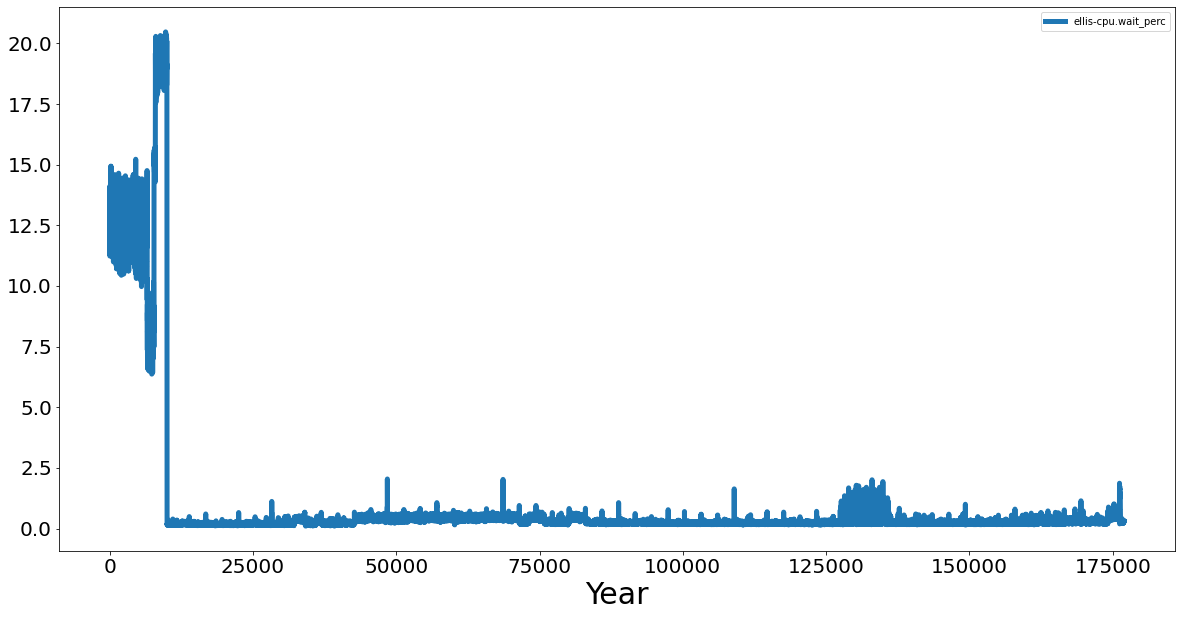

In [ ]:
cpu_wait_perc = df_Ellis[['ellis-cpu.wait_perc']] 
cpu_wait_perc.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20) 
plt.xlabel('Year', fontsize=30);

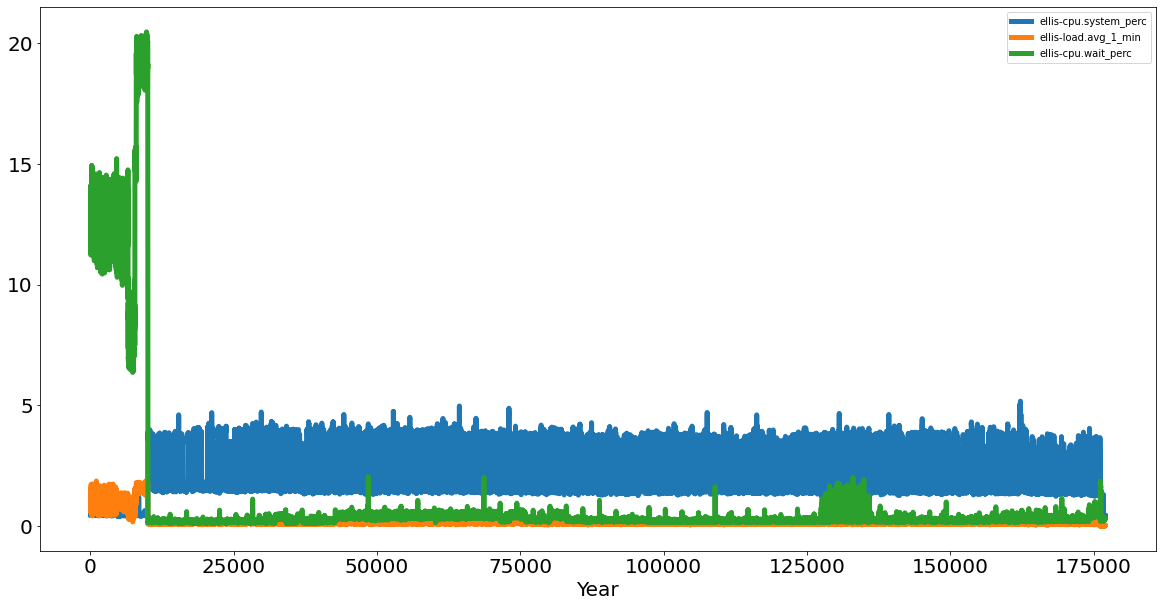

In [ ]:
df_dg = pd.concat([cpu_system_perc.rolling(12).mean(), load_avg_1_min.rolling(12).mean(),cpu_wait_perc.rolling(12).mean()], axis=1) 
df_dg.plot(figsize=(20,10), linewidth=5, fontsize=20) 
plt.xlabel('Year', fontsize=20); 

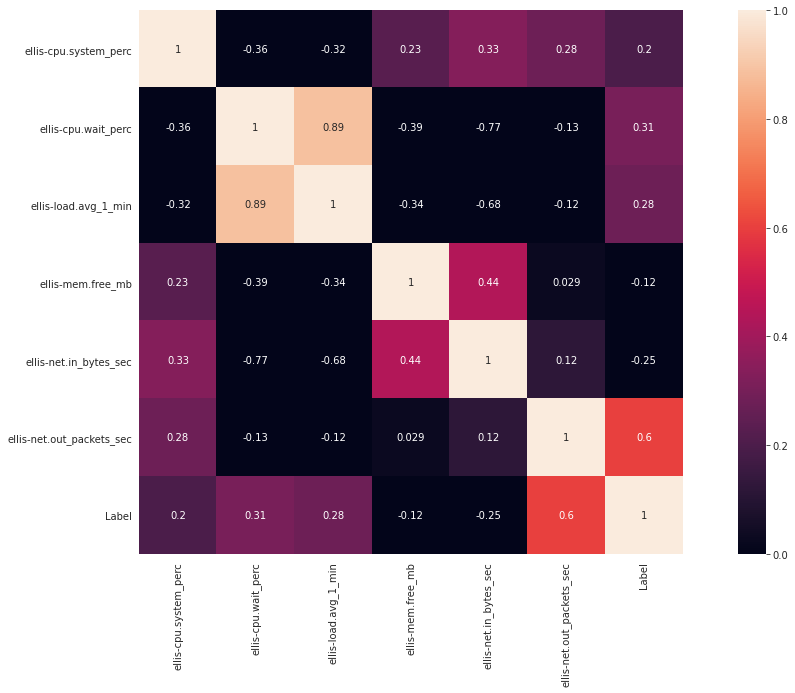

In [ ]:
# we establish the corrmartrice
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

correaltionMatrice = df_Ellis.corr()
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(correaltionMatrice, cbar=True, vmin=0, vmax=1, square=True, annot=True);
plt.show()

In [ ]:
df_Ellis.corrwith(df_Ellis['ellis-load.avg_1_min'])

ellis-cpu.system_perc       -0.316956
ellis-cpu.wait_perc          0.886739
ellis-load.avg_1_min         1.000000
ellis-mem.free_mb           -0.335300
ellis-net.in_bytes_sec      -0.681849
ellis-net.out_packets_sec   -0.116851
Label                        0.279330
dtype: float64

In [ ]:
## ## using multivariate feature 

features_3 = ['ellis-cpu.wait_perc', 'ellis-load.avg_1_min', 'ellis-net.in_bytes_sec', 'Label']

features = df_Ellis[features_3]
features.index = df_Ellis['Timestamp']
features.head()

,ellis-cpu.wait_perc,ellis-load.avg_1_min,ellis-net.in_bytes_sec,Label
Timestamp,,,,
14-09-2016 0:00,12.9,1.73,5413.200,1
14-09-2016 0:00,10.3,1.79,5201.667,1
14-09-2016 0:01,11.8,1.52,5370.733,1
14-09-2016 0:01,12.9,1.43,5292.467,1
14-09-2016 0:02,12.1,1.44,5318.167,1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9828364c50>,
      dtype=object)

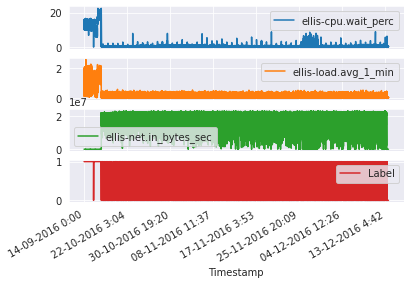

In [ ]:
features.plot(subplots=True)

In [ ]:
features = features.values

In [ ]:
### standardize data
train_split = 141600
tf.random.set_seed(13)

### standardize data
features_mean = features[:train_split].mean()
features_std = features[:train_split].std()
features  = (features - features_mean)/ features_std

print(type(features))
print(features.shape)


<class 'numpy.ndarray'>
(177000, 4)


In [ ]:
### create mutlivariate data

def mutlivariate_data(features , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(features)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(features[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)

In [ ]:
### generate multivariate data

history = 720
future_target = 72
STEP = 6

x_train_ss , y_train_ss = mutlivariate_data(features , features[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = mutlivariate_data(features , features[:,1] , train_split , None , history ,
                                        future_target, STEP, single_step = True)

print(x_train_ss.shape , y_train_ss.shape)
print(x_val_ss.shape , y_val_ss.shape)

(140880, 120, 4) (140880,)
(34608, 120, 4) (34608,)


In [ ]:
## tensorflow dataset
batch_size = 256
buffer_size = 10000

train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)

<RepeatDataset shapes: ((None, 120, 4), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 120, 4), (None,)), types: (tf.float64, tf.float64)>


In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
from keras.layers import Activation, Dense, Dropout
### Modelling using LSTM
steps = 50

EPOCHS =20

single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32, return_sequences=False, input_shape = x_train_ss.shape[-2:]))
single_step_model.add(tf.keras.layers.Dropout(0.3))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mae',metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
#single_step_model.compile(loss='mse', optimizer='rmsprop')
single_step_model_history = single_step_model.fit(train_ss, epochs = EPOCHS , 
                                                  steps_per_epoch =steps, validation_data = val_ss,
                                                  validation_steps = 50)
single_step_model.summary()



Epoch 1/20
50/50 [==============================] - 9s 45ms/step - loss: 0.1683 - rmse: 0.2196 - val_loss: 0.0219 - val_rmse: 0.0226
Epoch 2/20
50/50 [==============================] - 2s 35ms/step - loss: 0.0866 - rmse: 0.1100 - val_loss: 0.0134 - val_rmse: 0.0140
Epoch 3/20
50/50 [==============================] - 2s 35ms/step - loss: 0.0560 - rmse: 0.0704 - val_loss: 0.0052 - val_rmse: 0.0057
Epoch 4/20
50/50 [==============================] - 2s 35ms/step - loss: 0.0487 - rmse: 0.0611 - val_loss: 0.0041 - val_rmse: 0.0046
Epoch 5/20
50/50 [==============================] - 2s 33ms/step - loss: 0.0458 - rmse: 0.0576 - val_loss: 0.0109 - val_rmse: 0.0111
Epoch 6/20
50/50 [==============================] - 2s 35ms/step - loss: 0.0432 - rmse: 0.0542 - val_loss: 0.0084 - val_rmse: 0.0086
Epoch 7/20
50/50 [==============================] - 2s 36ms/step - loss: 0.0401 - rmse: 0.0504 - val_loss: 0.0080 - val_rmse: 0.0082
Epoch 8/20
50/50 [==============================] - 2s 35ms/step - lo

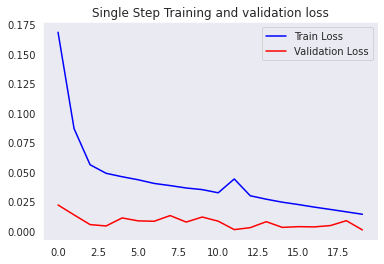

In [ ]:
## plot train test loss 

def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

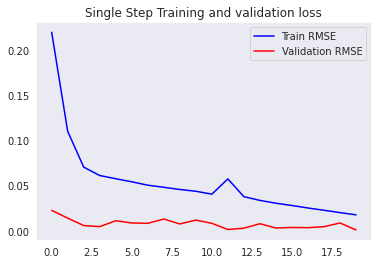

In [ ]:
## plot train test loss 

def plot_loss(history , title):
  loss = history.history['rmse']
  val_loss = history.history['val_rmse']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train RMSE')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation RMSE')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

In [ ]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

In [ ]:
### Moving window average

def MWA(history):
  return np.mean(history)

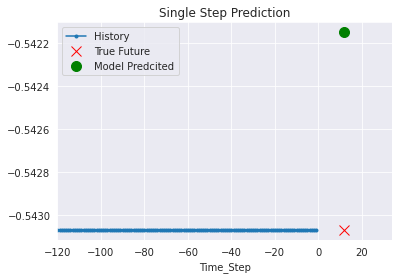

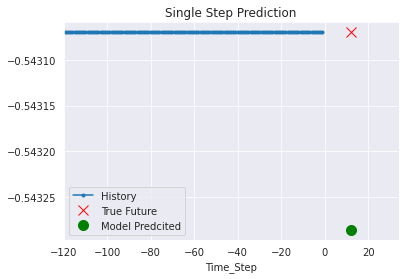

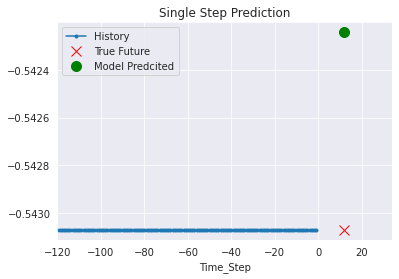

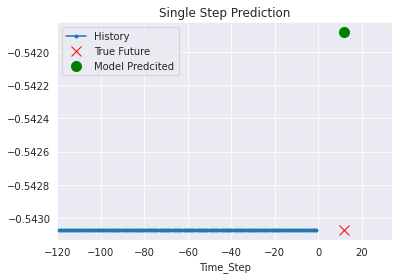

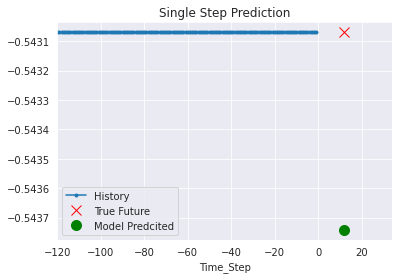

In [ ]:
# plot time series and predicted values

for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

# **MultiStep Forcasting**

In [ ]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = mutlivariate_data(features, features[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = mutlivariate_data(features, features[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(140880, 120, 4)
(140880, 72)


In [ ]:
#  TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

In [ ]:
print(train_data_multi)
print(val_data_multi)

<RepeatDataset shapes: ((None, 120, 4), (None, 72)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 120, 4), (None, 72)), types: (tf.float64, tf.float64)>


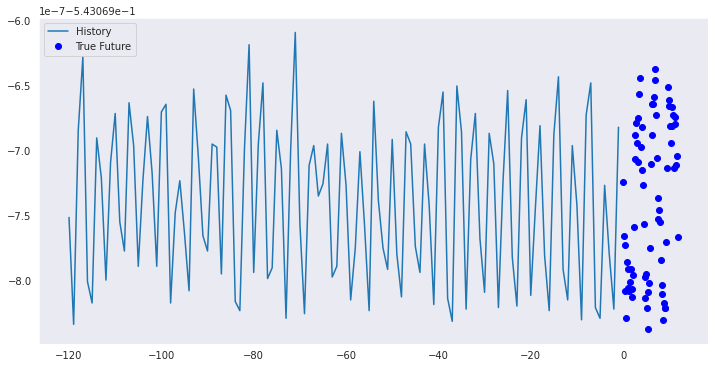

In [ ]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
#aDD dropout layer (0.3)
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae',metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/20
50/50 [==============================] - 24s 409ms/step - loss: 0.3414 - rmse: 0.4277 - val_loss: 0.1861 - val_rmse: 0.2886
Epoch 2/20
50/50 [==============================] - 20s 400ms/step - loss: 0.1268 - rmse: 0.2198 - val_loss: 0.0671 - val_rmse: 0.1290
Epoch 3/20
50/50 [==============================] - 19s 384ms/step - loss: 0.0474 - rmse: 0.0985 - val_loss: 0.0481 - val_rmse: 0.0667
Epoch 4/20
50/50 [==============================] - 19s 388ms/step - loss: 0.0288 - rmse: 0.0438 - val_loss: 0.0330 - val_rmse: 0.0363
Epoch 5/20
50/50 [==============================] - 19s 386ms/step - loss: 0.0228 - rmse: 0.0275 - val_loss: 0.0358 - val_rmse: 0.0367
Epoch 6/20
50/50 [==============================] - 20s 393ms/step - loss: 0.0210 - rmse: 0.0251 - val_loss: 0.0314 - val_rmse: 0.0319
Epoch 7/20
50/50 [==============================] - 19s 380ms/step - loss: 0.0198 - rmse: 0.0234 - val_loss: 0.0297 - val_rmse: 0.0307
Epoch 8/20
50/50 [==============================] - 19s

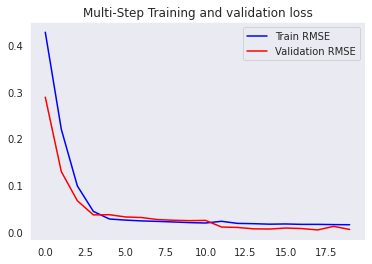

In [ ]:
plot_loss(multi_step_history, 'Multi-Step Training and validation loss')

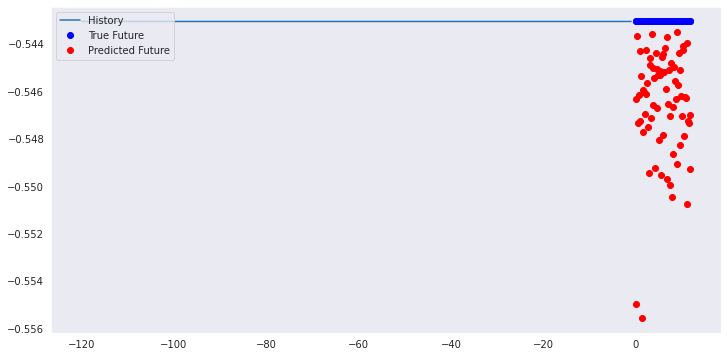

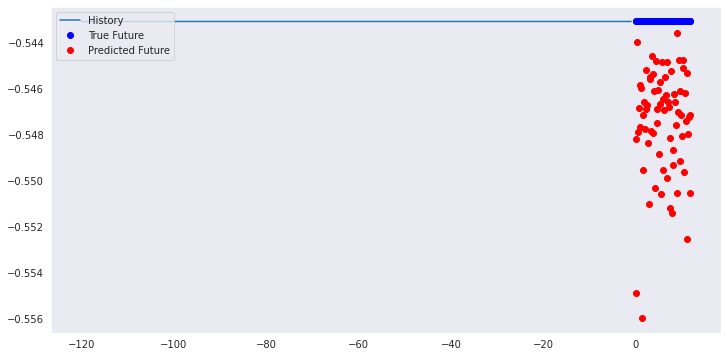

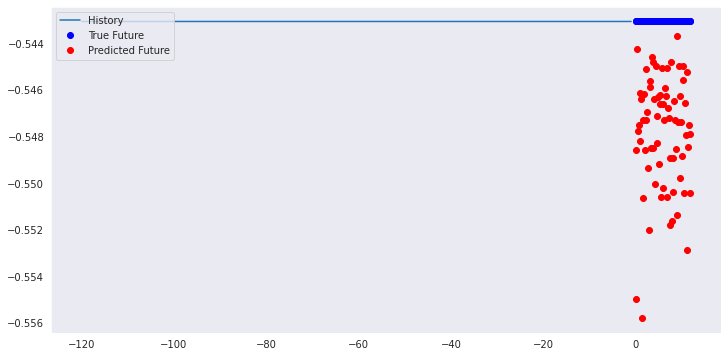

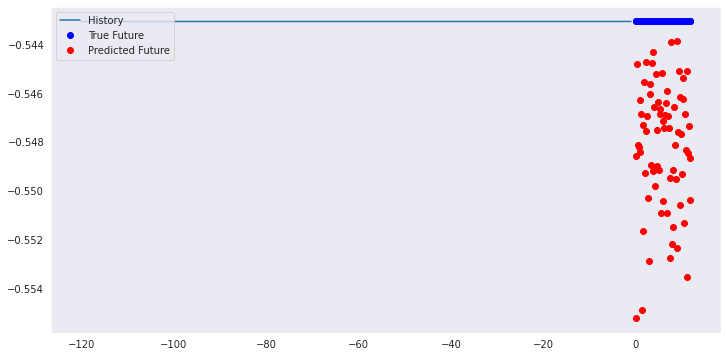

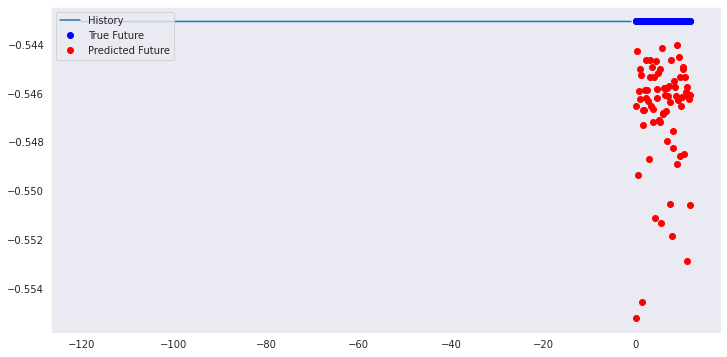

In [ ]:
for x, y in val_data_multi.take(5):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
scores = multi_step_model.evaluate(x_train_multi, y_train_multi, verbose=1, batch_size=200)
print('MAE: {}'.format(scores[1]))

705/705 [==============================] - 22s 30ms/step - loss: 0.0048 - rmse: 0.0058
MAE: 0.005751027259975672


In [ ]:
scores_test = multi_step_model.evaluate(x_val_multi, y_val_multi, verbose=1, batch_size=200)
print('MAE: {}'.format(scores[1]))


174/174 [==============================] - 5s 31ms/step - loss: 0.0043 - rmse: 0.0052
MAE: 0.005751027259975672
